In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spanish-ab-test/user_table.csv
/kaggle/input/spanish-ab-test/test_table.csv


1. 背景与目标

公司针对西班牙语市场进行了一次 A/B 测试：

Control 组 (旧版翻译)：所有用户使用统一的“西班牙（Spain）版本翻译”。

Test 组 (本地化翻译)：拉美各国用户使用由本国翻译的版本（墨西哥用户看墨西哥翻译，阿根廷用户看阿根廷翻译等）。
目标是验证 本地化翻译是否能提升拉美地区用户转化率。

2. 数据与方法

数据来源：test_table（实验分组、转化等） + user_table（用户属性）。

数据清洗：

Spain 用户始终在 control 组，已剔除。

ads_channel 缺失属正常（非广告来源用户），保留。


分析方法：

EDA（分组样本量、国家分布、时间趋势）。

转化率对比。

显著性检验：使用 二项比例 z-test。

3. 主要发现

实验分流

Test / Control 分配接近 50/50，分流正常。

每日样本量稳定，没有偏差。

整体转化率对比（LatAm 用户）

Control: 4.83%

Test: 4.34%

差异：-0.49%（下降约 10%）

显著性检验

z-test, p < 0.05

结论：Test 组显著低于 Control 组，结果并非偶然。

国家维度

多数拉美国家 Test 转化率 < Control。

没有发现某个特定国家的提升效应。

Spain 的基准转化率 (~8%) 远高于拉美 (~5%)，说明西班牙市场天然转化更高。

时间维度

在整个实验期间（多日），Test 组转化率每天都低于 Control。

差距稳定存在，不是单日异常。

4. 结论

本地化翻译版本在拉美用户中显著降低转化率。

翻译并没有起到预期的正面作用，结果是 负面且统计显著。

Spain 用户转化率显著高于拉美用户，差异与翻译无关，可能源于市场成熟度、支付习惯、购买力等其他因素。

5. 建议

停止推广本地化翻译版本，避免进一步损失转化。

用户调研/定性分析：调查拉美用户是否觉得本地化翻译不自然或降低信任。

替代方案：

保留统一的 Spain 翻译版本。

或者先做小规模用户调研 / 定性测试，再考虑迭代。

后续实验：可以测试除翻译以外的因素（如支付方式、推荐逻辑、UI 差异），寻找真正影响拉美转化的关键。

In [2]:
test = pd.read_csv("/kaggle/input/spanish-ab-test/test_table.csv")
user = pd.read_csv("/kaggle/input/spanish-ab-test/user_table.csv")

In [3]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [5]:
user.isnull().sum()

user_id    0
sex        0
age        0
country    0
dtype: int64

In [6]:
test.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [7]:
print("there are %i unique users"%len(user['user_id'].unique()))
print("there are %i unique users"%len(test['user_id'].unique()))

there are 452867 unique users
there are 453321 unique users


In [8]:
all = pd.merge(left=test,right=user,how='left',on='user_id')
all

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
453316,425010,2015-12-04,SEO,Web,ES,NaN,FireFox,0,0,M,50.0,Mexico
453317,826793,2015-12-01,SEO,Mobile,ES,NaN,Android_App,0,1,F,20.0,Colombia
453318,514870,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,M,25.0,Spain
453319,785224,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,1,M,21.0,Colombia


In [9]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 41.5+ MB


In [10]:
all.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

In [11]:
# 2. 检查 Spain 用户是否都在 control 组
spain_test_users = all.query("country == 'Spain' and test == 1")
print("Spain 用户中被分到 test 的人数:", spain_test_users.shape[0])  # 应该是 0

Spain 用户中被分到 test 的人数: 0


In [12]:
# 3. 检查 test vs control 样本量
print("\n== Test / Control 样本量 ==")
print(all['test'].value_counts(normalize=True))


== Test / Control 样本量 ==
test
0    0.523554
1    0.476446
Name: proportion, dtype: float64


In [13]:
# 4. 转化率对比（整体）
conv_rate = all.groupby('test')['conversion'].mean()
print("\n== 转化率对比 ==")
print(conv_rate)


== 转化率对比 ==
test
0    0.055179
1    0.043425
Name: conversion, dtype: float64


In [14]:
# 5. 按国家检查 test/control 样本分布
print("\n== 各国 Test/Control 分布 ==")
country_split = all.groupby(['country','test']).size().unstack(fill_value=0)
print(country_split.head())


== 各国 Test/Control 分布 ==
test            0      1
country                 
Argentina    9356  37377
Bolivia      5550   5574
Chile        9853   9884
Colombia    27088  26972
Costa Rica   2660   2649


In [15]:
# 6. 按国家计算转化率
print("\n== 各国转化率对比 ==")
country_conv = all.groupby(['country','test'])['conversion'].mean().unstack()
print(country_conv.head())


== 各国转化率对比 ==
test               0         1
country                       
Argentina   0.015071  0.013725
Bolivia     0.049369  0.047901
Chile       0.048107  0.051295
Colombia    0.052089  0.050571
Costa Rica  0.052256  0.054738


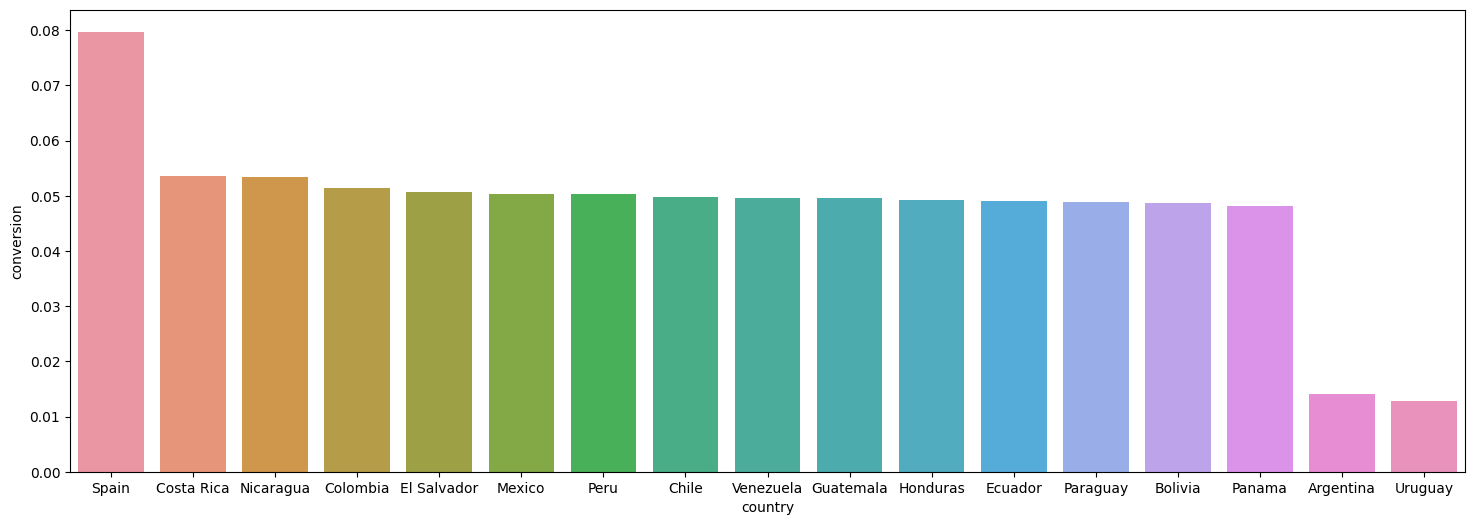

In [16]:
# First check that Spain converts much better than the rest of LatAm countries
groupby_country = all[['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending=False)

# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.show()

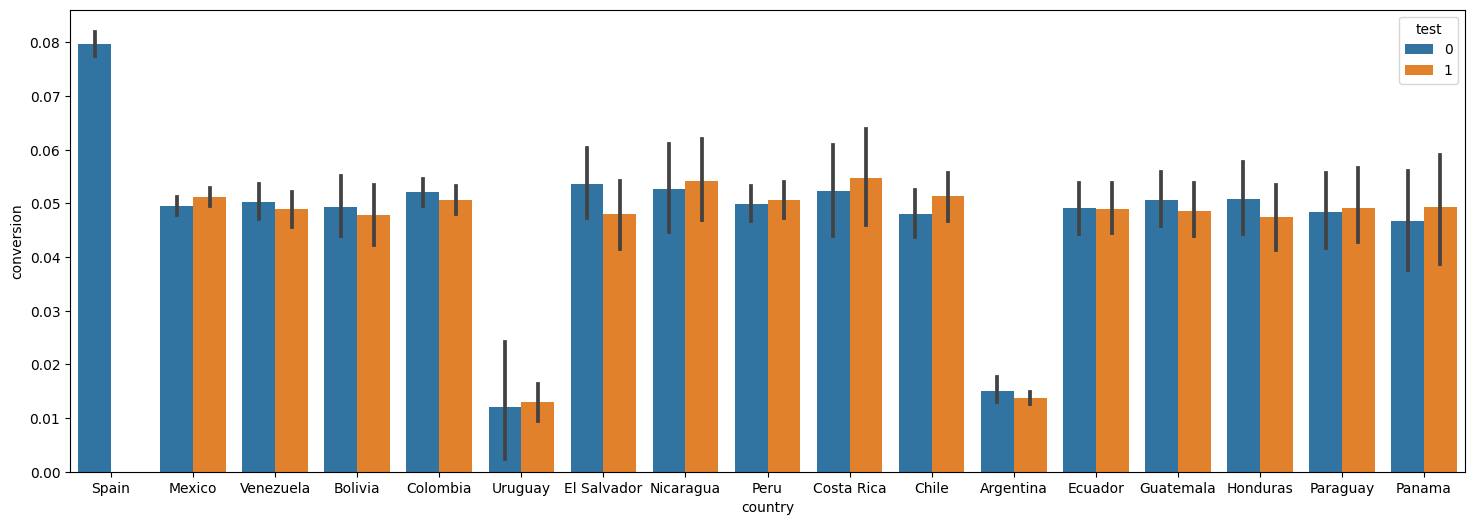

In [17]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=all, ax=ax)
plt.show()

In [18]:
from statsmodels.stats.proportion import proportions_ztest
# A/B test
test_data = all[all['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

print(test_val.mean(), '\t', cont_val.mean())

0.043424713982118966 	 0.04833042316066309


## 进行假设性检验
原假设 H(0): 两组的转化率相同：test conversion rate = not test conversion rate  也就是说，本地化翻译对转化率没有影响。

备择假设 H(1): 双尾检验 test 组转化率更低


In [19]:
success = [test_val.sum(), cont_val.sum()]
# 样本数
nobs = [len(test_val), len(cont_val)]

stat, pval = proportions_ztest(success, nobs, alternative='two-sided')
print("Z统计量 =", stat, "p值 =", pval)

Z统计量 = -7.422021422012666 p值 = 1.1534615081524855e-13


得出结果在检验中p值小于0.05，这意味着在显著性水平 5% 下，我们有足够证据 拒绝原假设H（0），即本地化翻译对转化率没有影响

本地化翻译 显著降低 了转化率（不是随机波动造成的）。
换句话说，这次 A/B test 的结果是 负面且统计显著。

In [20]:
data_without_spain = all[all['country'] !='Spain']
data_without_spain.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


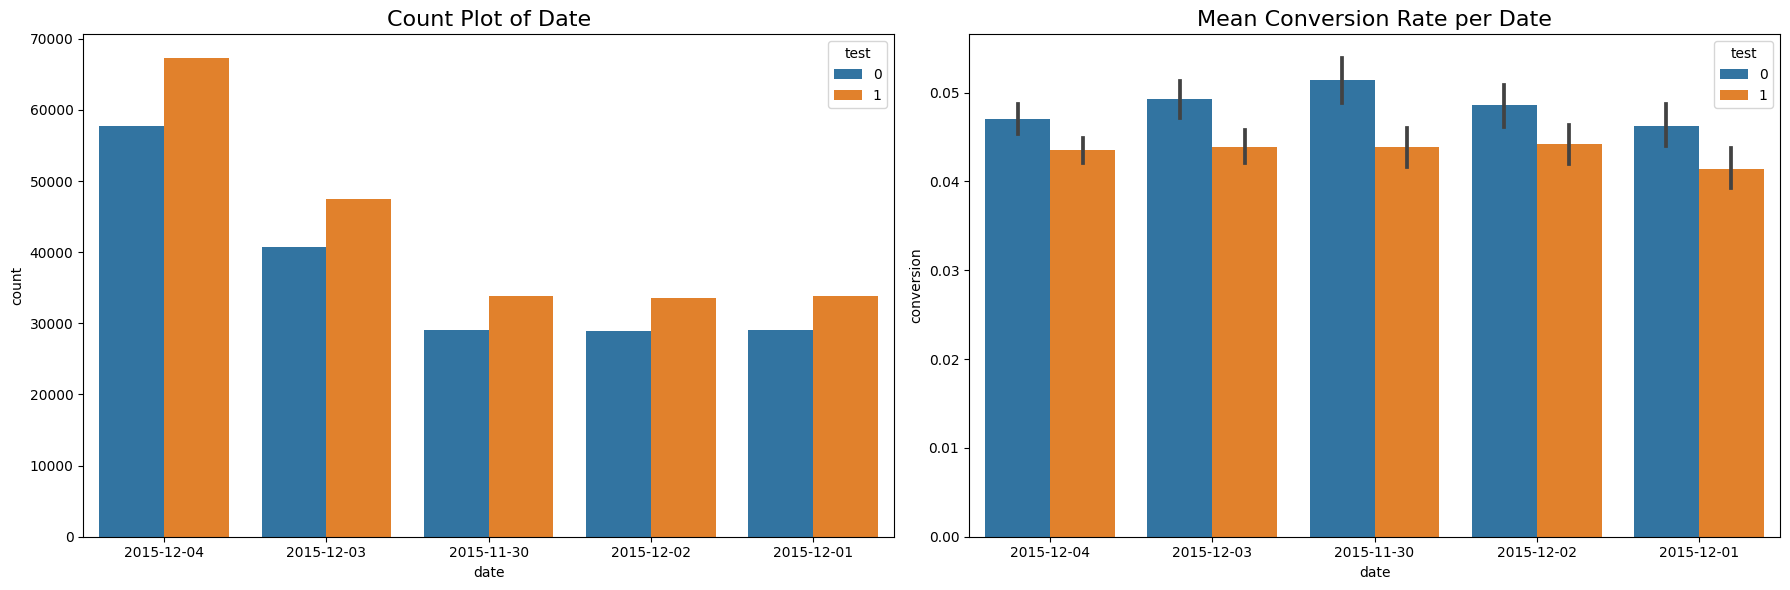

In [21]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=data_without_spain, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

sns.barplot(x='date', y='conversion', hue='test', data=data_without_spain, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
plt.tight_layout()
plt.show()

## 从左图中可以看到
每一天 test 和 control 的样本量都比较接近，没有出现某天 test 远多于 control 的极端情况。

这说明 实验分流是稳定的，每天都保持大约 50/50 的分配，没有随机化失败的迹象。

## 从右图中可以看到
在每一天，test 的转化率都低于 control。

差距虽然不大，但趋势 一致（test < control），而且跨天都保持这种情况。

置信区间之间几乎没有明显重叠，说明差距不是偶然的。

这说明 test 的劣势并不是“某一天异常”导致的，而是 跨时间段稳定存在。

Text(0, 0.5, 'conversion rate')

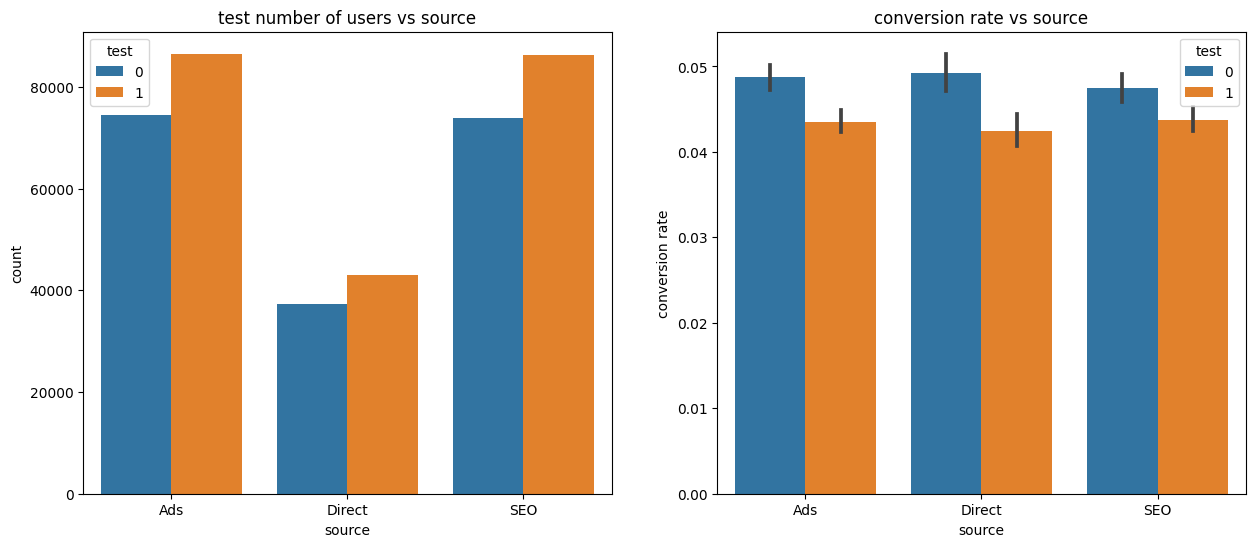

In [22]:
#visualization of source
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='source',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs source")

sns.barplot(x='source',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs source')
axes[1].set_ylabel('conversion rate')

Text(0, 0.5, 'conversion rate')

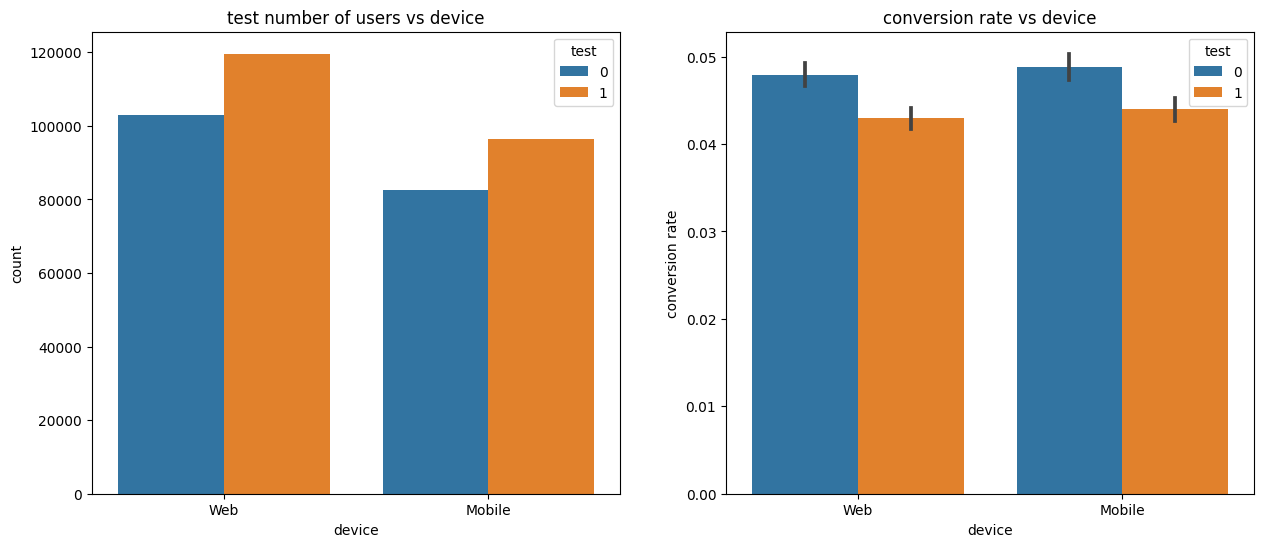

In [23]:
#visulization of device
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='device',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs device")

sns.barplot(x='device',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs device')
axes[1].set_ylabel('conversion rate')

Text(0, 0.5, 'conversion rate')

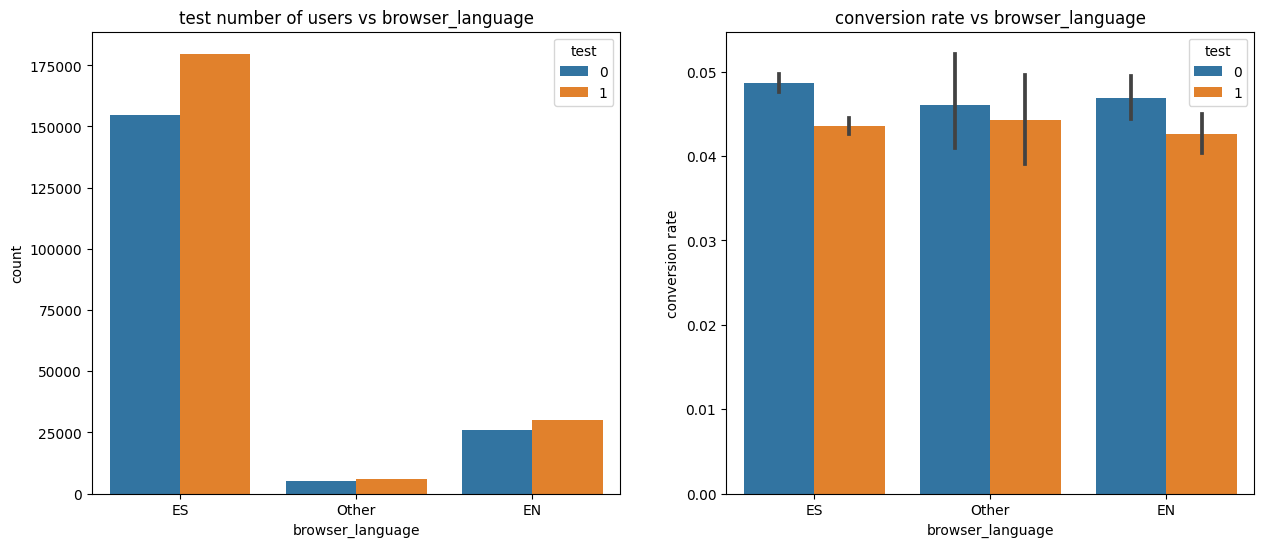

In [24]:
#visualization of browser language
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='browser_language',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs browser_language")

sns.barplot(x='browser_language',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs browser_language')
axes[1].set_ylabel('conversion rate')

Text(0, 0.5, 'conversion rate')

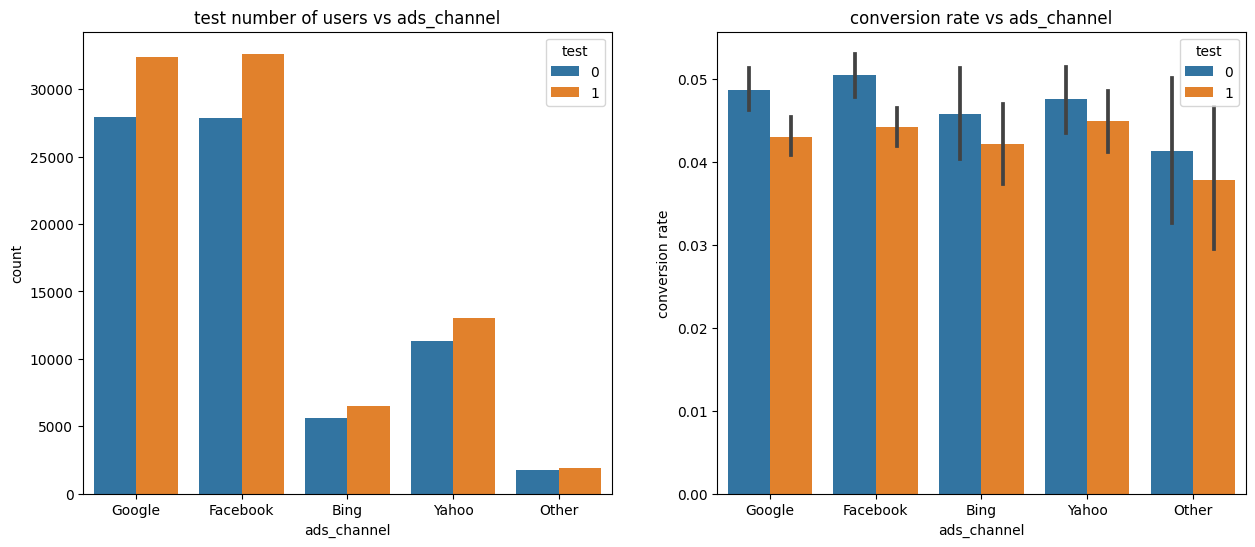

In [25]:
#visualization of ads channel
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='ads_channel',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs ads_channel")

sns.barplot(x='ads_channel',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs ads_channel')
axes[1].set_ylabel('conversion rate')

Text(0, 0.5, 'conversion rate')

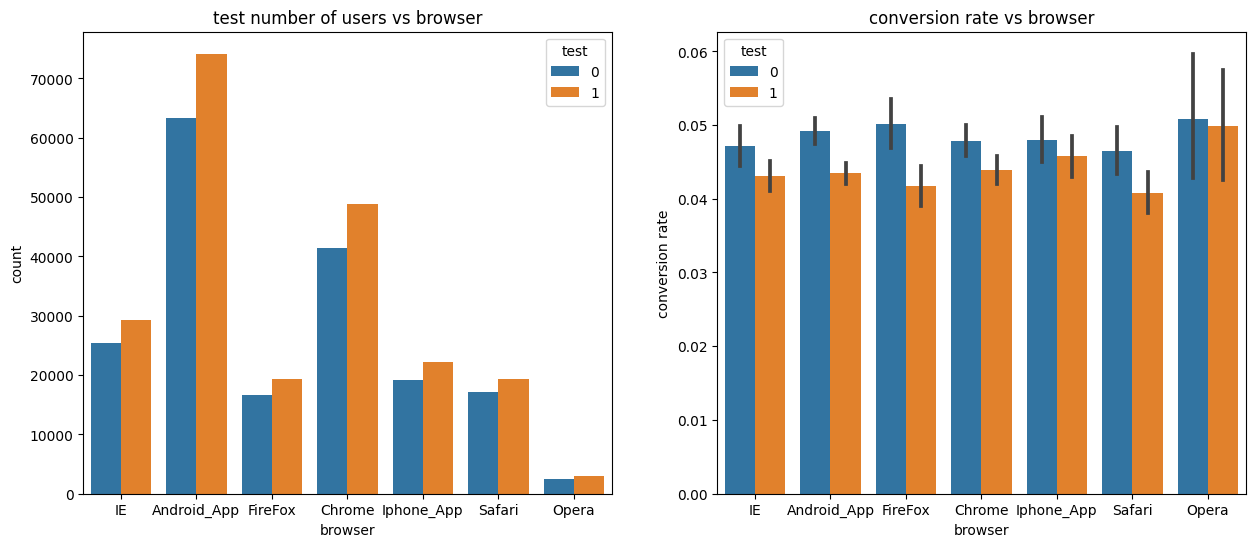

In [26]:
#visualization of browser 
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='browser',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs browser")

sns.barplot(x='browser',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs browser')
axes[1].set_ylabel('conversion rate')

Text(0, 0.5, 'conversion rate')

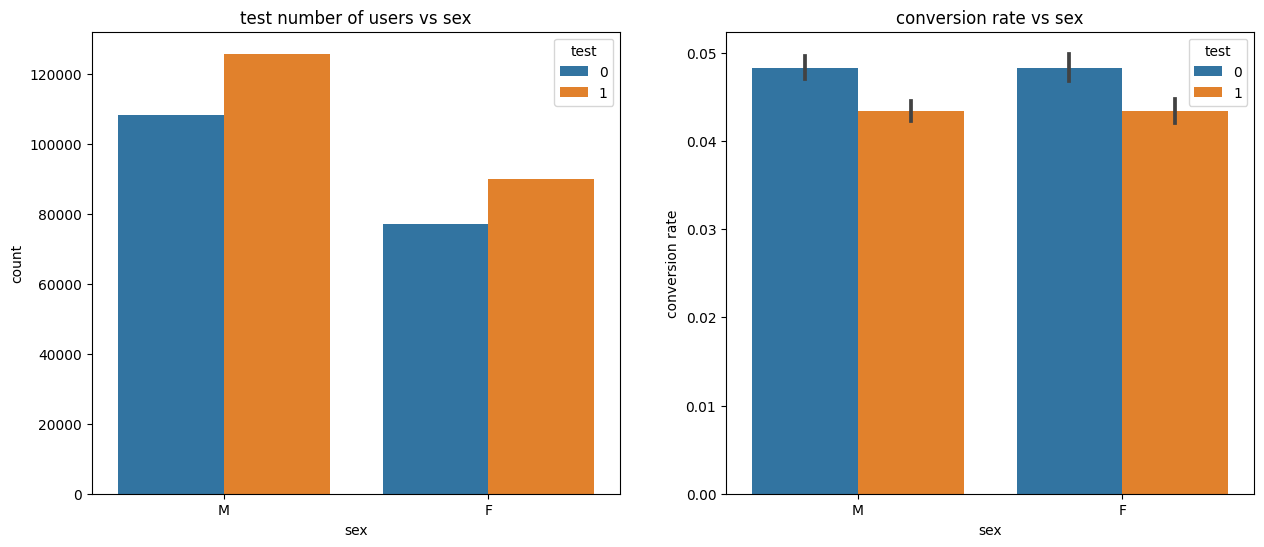

In [27]:
#visualization of sex
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='sex',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs sex")

sns.barplot(x='sex',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs sex')
axes[1].set_ylabel('conversion rate')

Text(0, 0.5, 'conversion rate')

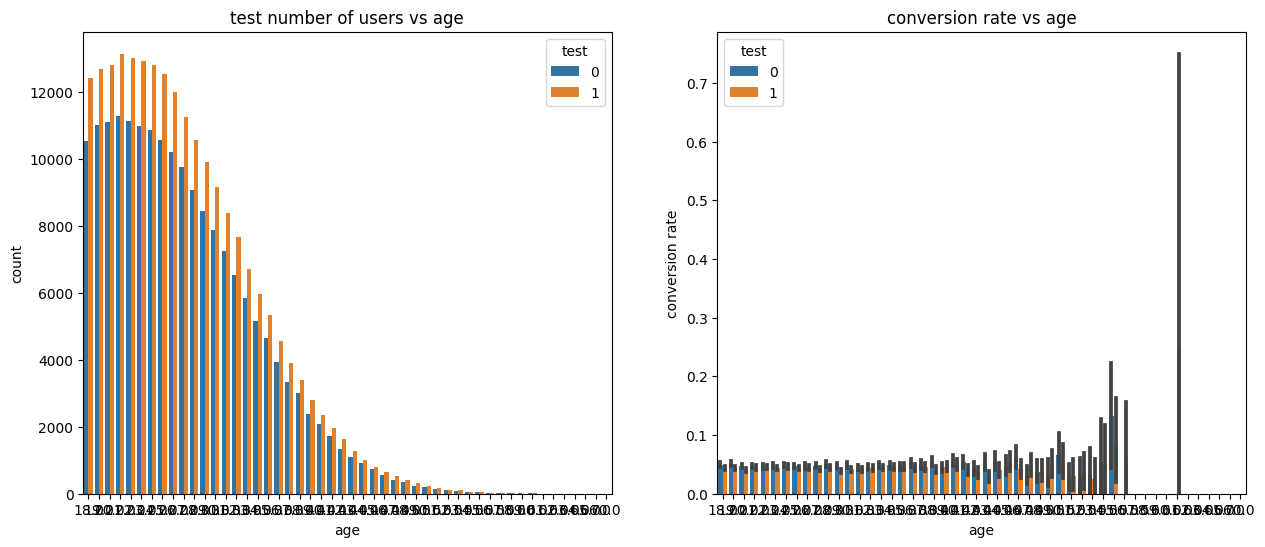

In [28]:
#visualization of age
fig, axes = plt.subplots(nrows =1, ncols=2,figsize=(15,6))
sns.countplot(x='age',hue='test',data=data_without_spain,ax=axes[0])
axes[0].set_title("test number of users vs age")

sns.barplot(x='age',y='conversion',hue='test',data=data_without_spain,ax=axes[1])
axes[1].set_title('conversion rate vs age')
axes[1].set_ylabel('conversion rate')

In [29]:
countries = [name for name in data_without_spain['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data_without_spain[(data_without_spain['country'] == country) & (data_without_spain['test'] == 1)]['conversion'].values
    cont_val = data_without_spain[(data_without_spain['country'] == country) & (data_without_spain['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------


NameError: name 'ttest_ind' is not defined

大多数国家 test < control

例如 Peru: test=0.0536 vs control=0.0564

Nicaragua: test=0.0541 vs control=0.0527（略高，但差异极小）

Argentina: test=0.0137 vs control=0.0151

整体趋势：test 组转化率普遍低于 control。

p 值普遍 > 0.05

所有国家的 p 值都大于 0.05（很多甚至 0.5~0.9 之间）。

说明在单个国家层面，差异都没有达到统计显著。

这很常见，因为拆到每个国家后，样本量小，差异难以显著。

整体显著，但局部不显著

你之前做的整体检验（把所有拉美国家合并）得到 p < 0.05 → 说明总体差异显著。

但拆开到单个国家，效果被稀释，统计显著性消失。

这说明“转化率下降”是一个 广泛存在的小幅下降，而不是被某几个国家拉低。

整体结论可靠：在整个拉美市场，test 组显著低于 control。

国家层面结果：各国 test vs control 差异方向一致（大多数 test 更低），但幅度较小，单独检验不显著。

业务解释：本地化翻译并没有在某些国家产生明显坏结果，而是整体上 广泛小幅降低了转化率。

说明问题不是单一国家的翻译质量，而可能是“统一的西班牙版本”更通用、更易被理解。